In [22]:
import io
import os
from warnings import filterwarnings
from typing import List

filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from qiskit import QuantumCircuit

from constants import ALL_FILES, LABELS, TARGET_ASSETS_FOLDER, TOTAL_RUNS, STRATEGIES_DESCRIPTION, TOTAL_STRATEGIES, CLASSICAL_PORTION, QUANTUM_PORTION
from quantum_utils import player1, player2, player3, player4, dealer, gun, player_play, dealer_play

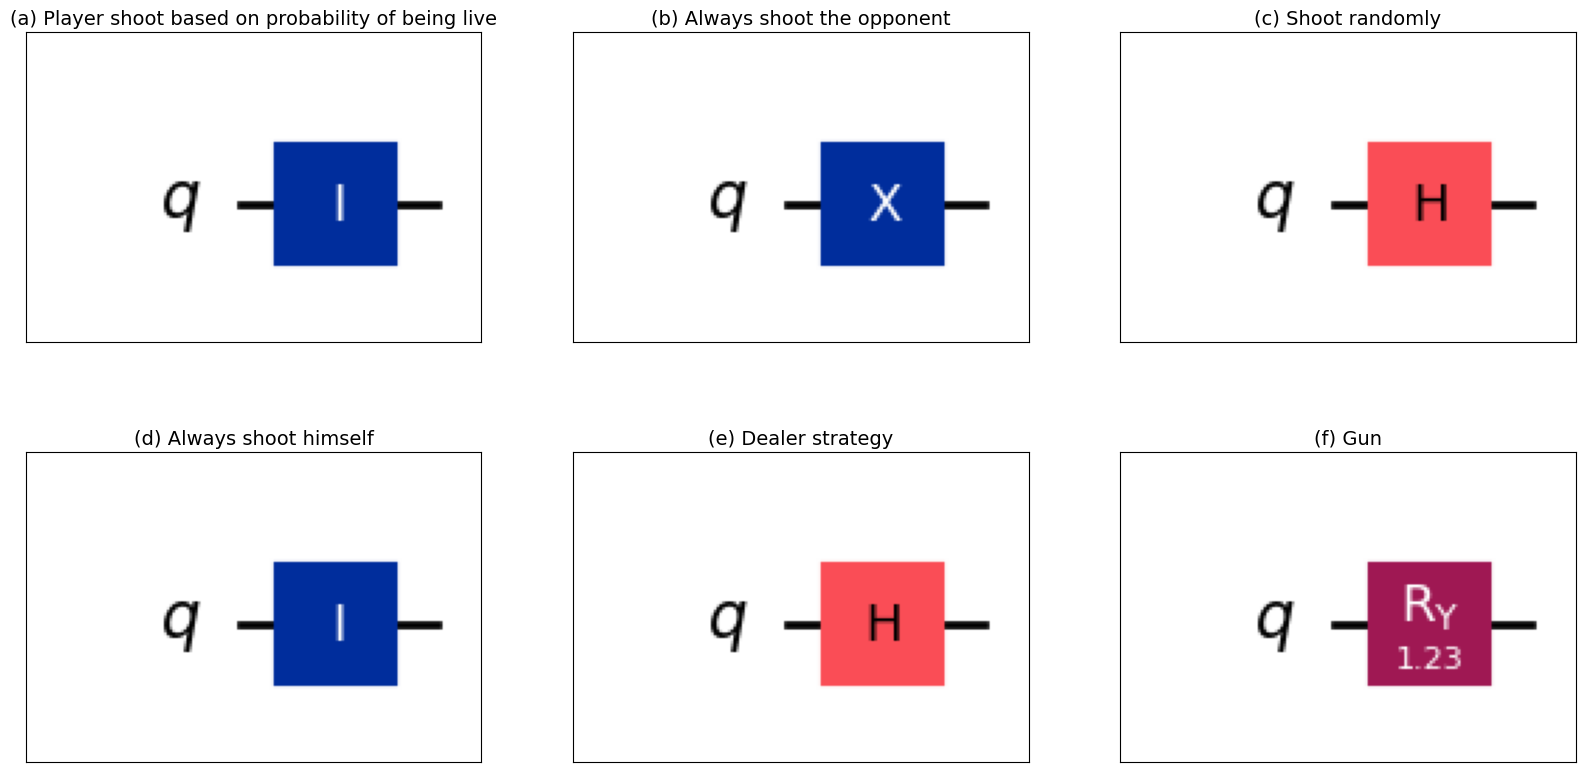

In [2]:
rows = 2
cols = 3

objs = (player1, player2, player3, player4, dealer,gun)
names = ('(a) Player shoot based on probability of being live', '(b) Always shoot the opponent', '(c) Shoot randomly', '(d) Always shoot himself', '(e) Dealer strategy', '(f) Gun')
current = 0
sns.reset_defaults()
fig, ax = plt.subplots(rows,cols, figsize=(20,10))

for i in range(rows):
    for j in range(cols):
        ax[i,j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax[i,j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)


        ax[i,j].set_title(names[current], fontsize=14)

        qc = QuantumCircuit(1)
        strategy = objs[current]
        op = strategy(3,1)
        op.label = None
        qc.append(op, [0])
        circuit = qc.draw('mpl')

        buf = io.BytesIO()
        circuit.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)

        img = Image.open(buf)

        ax[i,j].imshow(img)

        current += 1

fig.savefig(os.path.join(TARGET_ASSETS_FOLDER, 'quantum-strategies.png'), bbox_inches="tight")
plt.show()


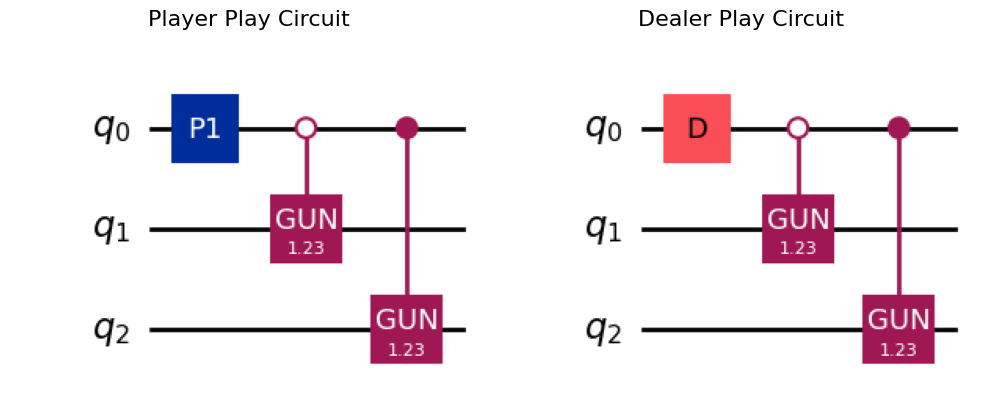

In [3]:
plots = 2
plays = (player_play(player1, 3, 1, name=""), dealer_play(dealer, 3, 1, name=""))
names = ("Player Play Circuit", "Dealer Play Circuit")

fig,ax = plt.subplots(1,plots,figsize=(10,5))

for i in range(plots):
    circuit = plays[i].draw('mpl')
    buf = io.BytesIO()
    circuit.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)

    img = Image.open(buf)

    ax[i].set_title(names[i], fontsize=16)

    ax[i].imshow(img)
    ax[i].axis('off')

fig.tight_layout()
fig.savefig(os.path.join(TARGET_ASSETS_FOLDER, 'quantum-plays.png'), bbox_inches="tight")
plt.show()

In [2]:
data = pd.DataFrame(columns=("winner", "label", "strategy", "rounds"))
labels = LABELS
datasets = ALL_FILES

print("---Classical---")
for label,dataset in zip(labels[:4],datasets[:4]):
    print(f"getting {label} from {dataset}")
    d = pd.read_csv(os.path.join(TARGET_ASSETS_FOLDER, dataset))
    grouped_data = d.groupby(["eval_i", "strategy", "rounds","winner"]).size().reset_index(name="total")
    grouped_data.drop("eval_i", axis=1)
    grouped_data["label"] = label
    data = pd.concat([data,grouped_data], ignore_index=True)

print("---Quantum---")
for label,dataset in zip(labels[4:],datasets[4:]):
    print(f"getting {label} from {dataset}")
    q = pd.read_csv(os.path.join(TARGET_ASSETS_FOLDER, dataset))
    q.drop("eval_i", axis=1)
    q["label"] = label
    data = pd.concat([data,q], ignore_index=True)

---Classical---
getting python random (random seed) from classical-results-no-seed.csv
getting python random (static seed) from classical-results-with-seed.csv
getting cpp (random seed) from classical-results-cpp-random-seed.csv
getting cpp (static seed) from classical-results-cpp-with-seed.csv
---Quantum---
getting quantum regular (default AER) from quantum-results-regular.csv
getting quantum modified (modified AER - random seed) from quantum-results-modified.csv
getting quantum noisy (IBM torino) from quantum-results-noisy-torino.csv
getting quantum noisy (IBM Fez) from quantum-results-noisy-fez.csv


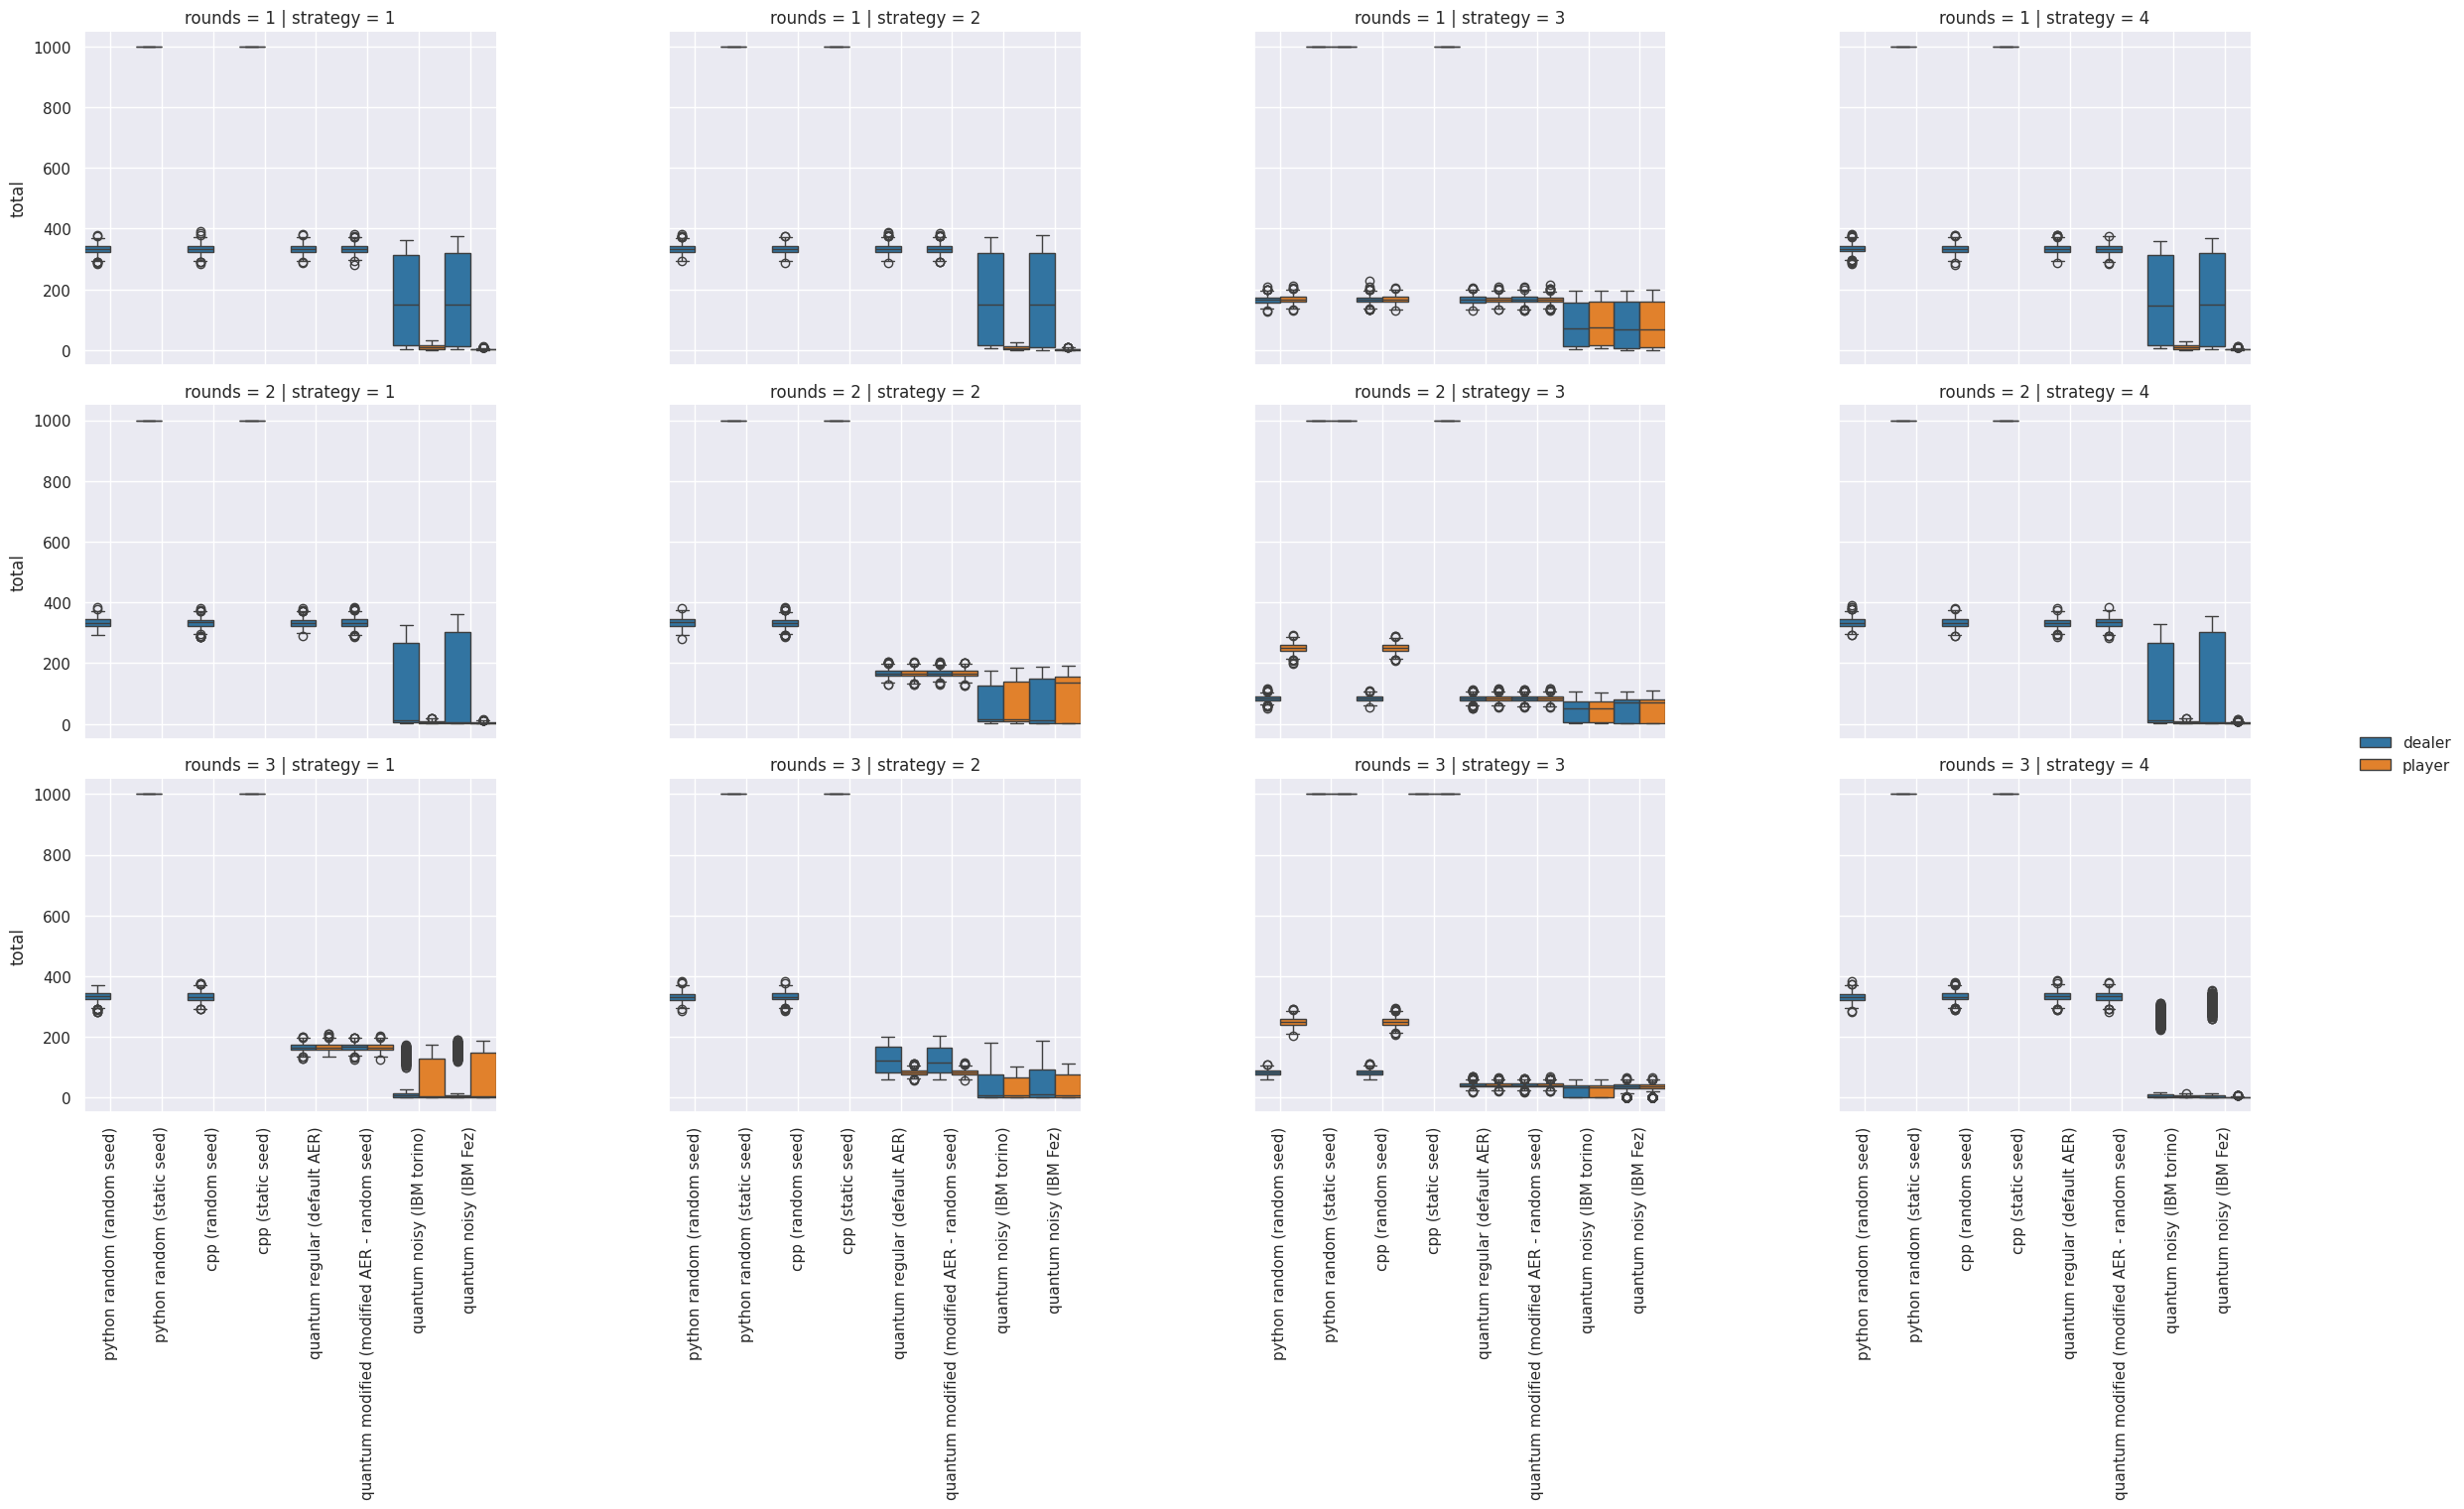

In [5]:
sns.set_context("paper")
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(data, row="rounds", col="strategy", height=4, aspect=1.5)

g.map_dataframe(sns.boxplot, y="total", hue="winner", x="label", palette="tab10", width=1)
g.add_legend()
g.tight_layout()
g.set_xlabels("")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=90)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

g.savefig(os.path.join(TARGET_ASSETS_FOLDER, "comparing-results.png"))
plt.show()

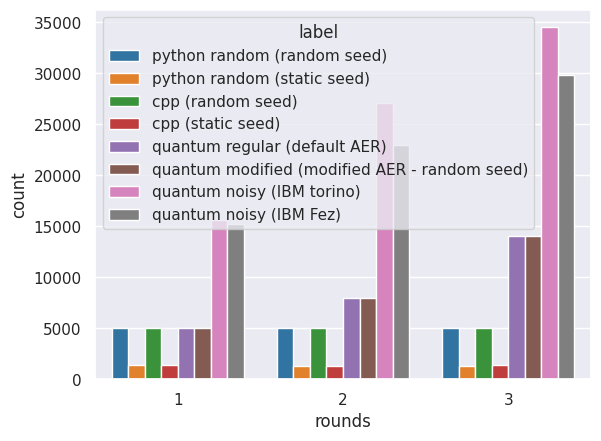

In [6]:
sns.set_theme(style="darkgrid")
sns.countplot(data=data, x="rounds", hue="label", palette="tab10")
plt.savefig(os.path.join(TARGET_ASSETS_FOLDER, "total_rounds.png"), bbox_inches="tight")
plt.show()


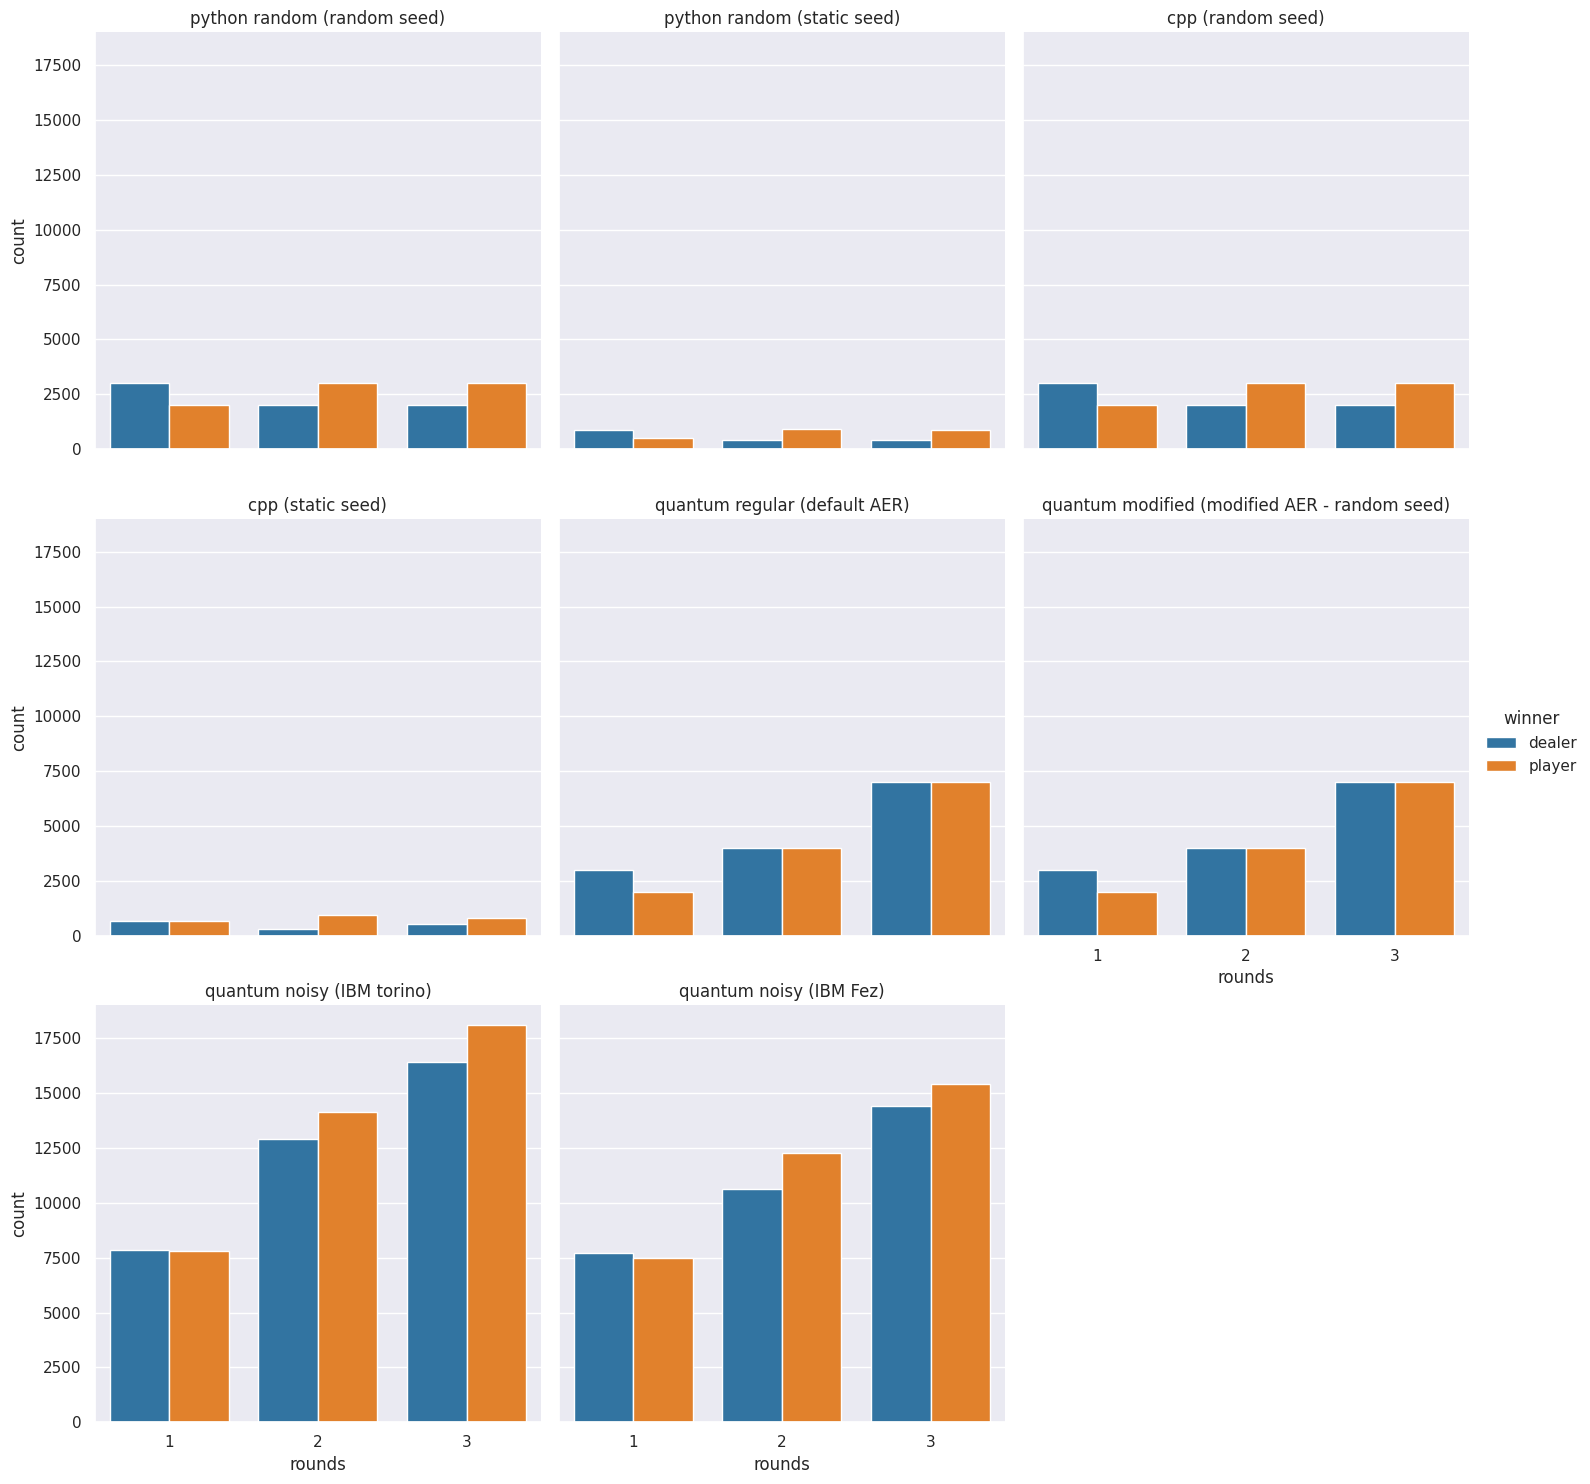

In [7]:
sns.set_theme(style="darkgrid")
g = sns.catplot(data=data, x="rounds", hue="winner", palette="tab10", col="label", kind="count", col_wrap=3)
g.set_titles(col_template="{col_name}")
plt.savefig(os.path.join(TARGET_ASSETS_FOLDER, "total_rounds_per_version.png"), bbox_inches="tight")
plt.show()

## Analysis for each version

To Understand how the players' winnings are distributed


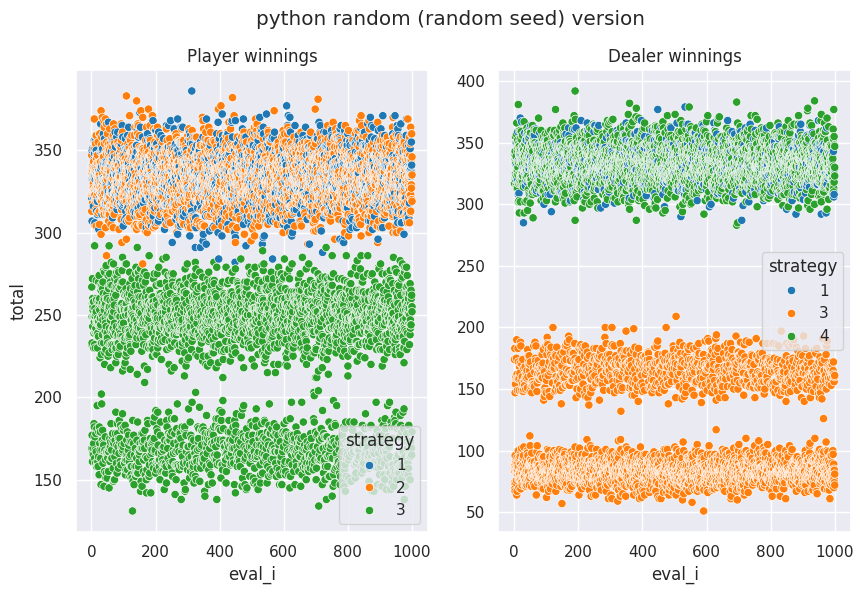

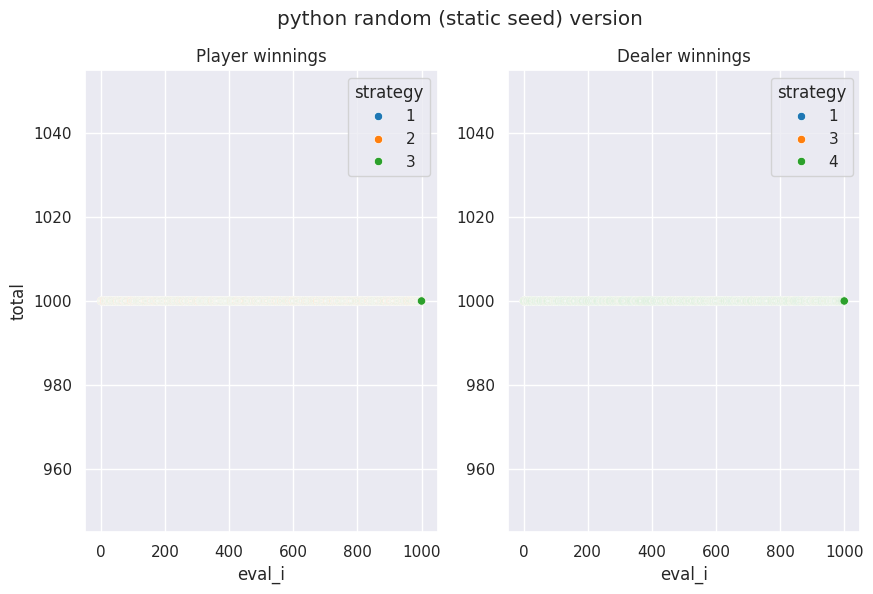

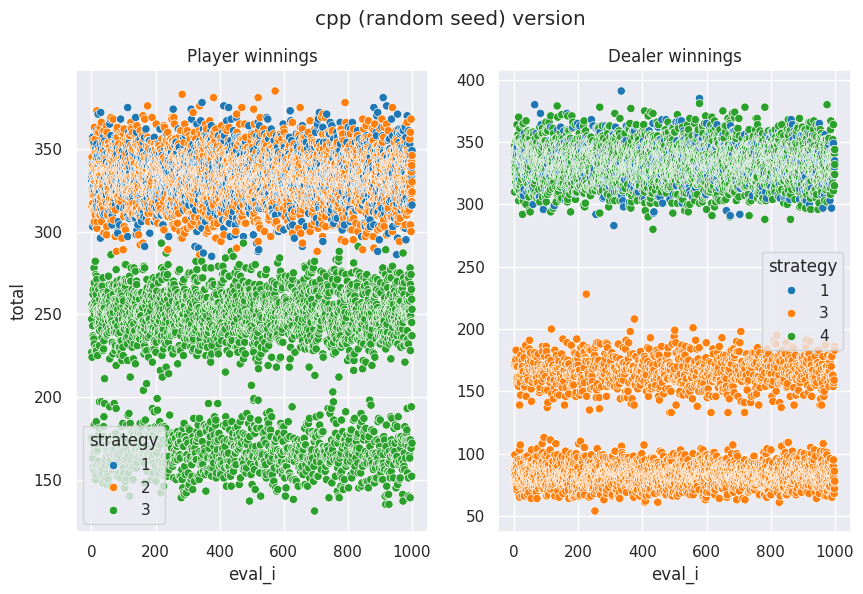

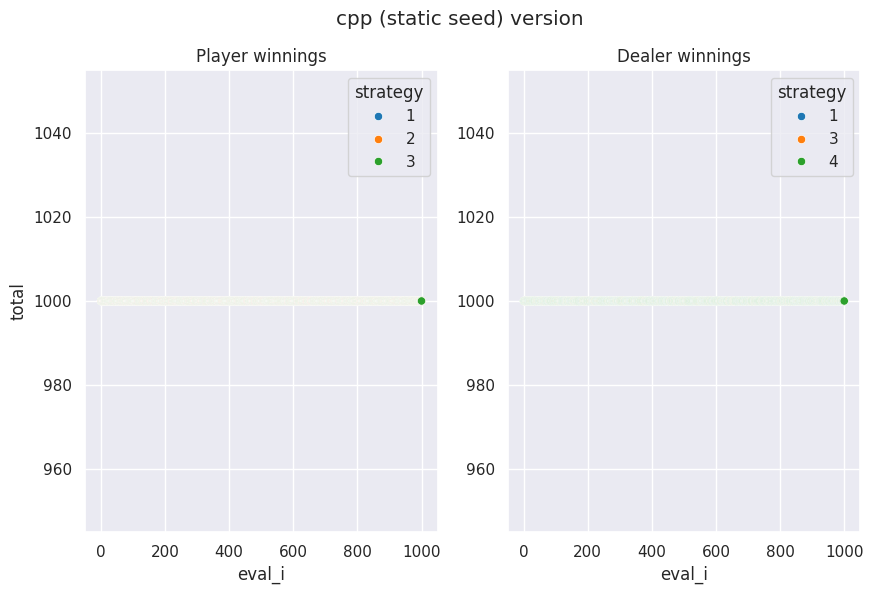

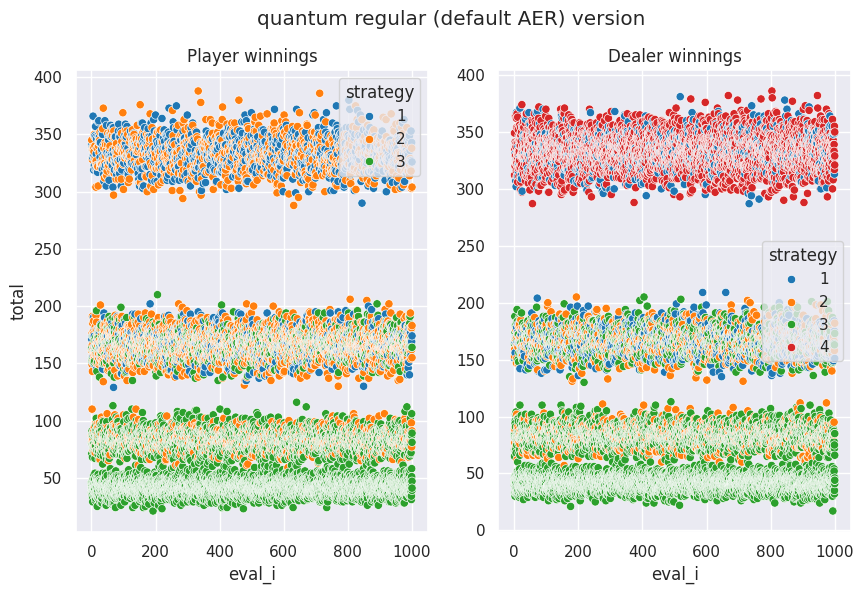

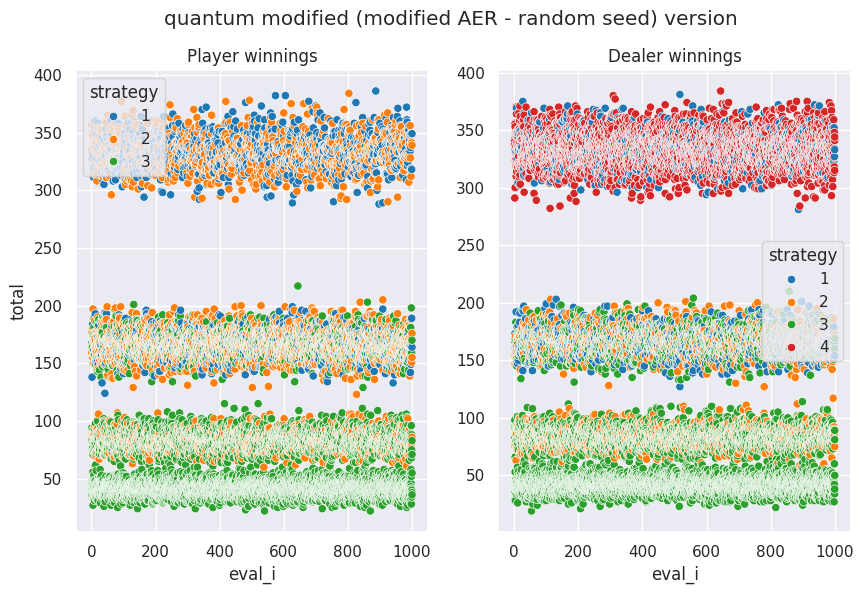

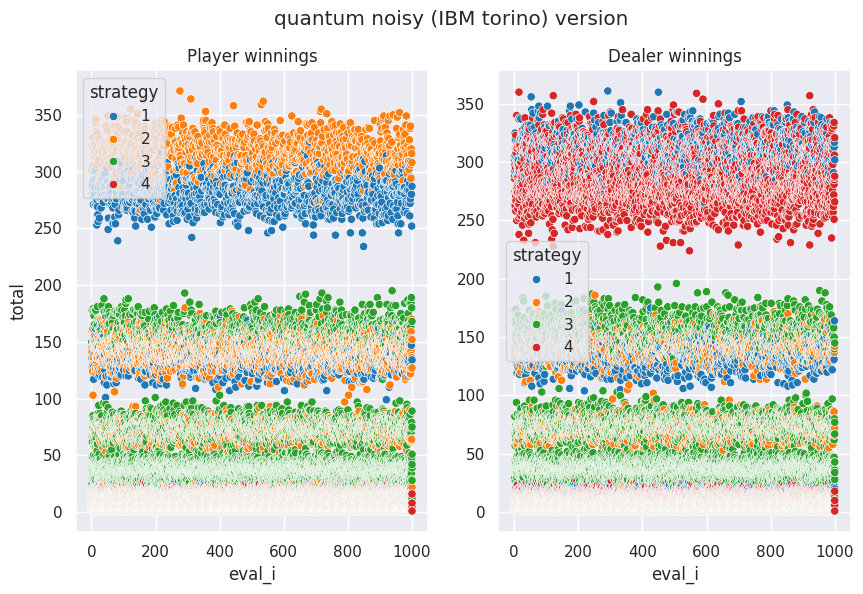

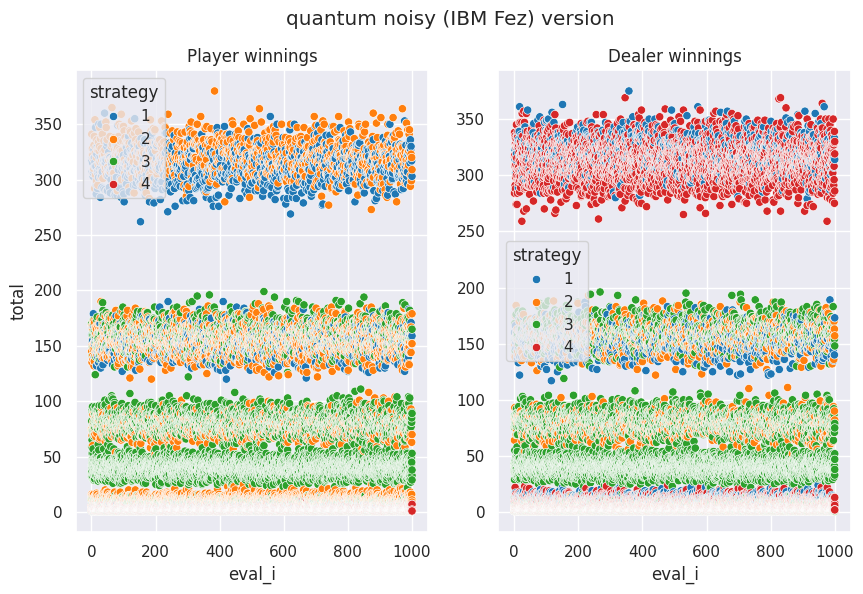

In [8]:
print("To Understand how the players' winnings are distributed")
for version in labels:
    subset = data[data["label"] == version]
    dealer_winnings = subset[subset["winner"] == "dealer"]
    player_winnings = subset[subset["winner"] == "player"]

    sns.set_theme(style="darkgrid")
    fig,ax = plt.subplots(1,2, figsize=(10,6))

    sns.scatterplot(data=player_winnings, x="eval_i", y="total", ax=ax[0], palette="tab10", hue="strategy")
    ax[0].set_title("Player winnings")

    sns.scatterplot(data=dealer_winnings, x="eval_i", y="total", ax=ax[1], palette="tab10", hue="strategy")
    ax[1].set_title("Dealer winnings")
    ax[1].set_ylabel("")

    fig.suptitle(f"{version} version")
    plt.savefig(os.path.join(TARGET_ASSETS_FOLDER, f"{version}-distribution-winnings-per-eval.png"), bbox_inches="tight")

    plt.show()

To Understand how many rounds each strategy takes to win


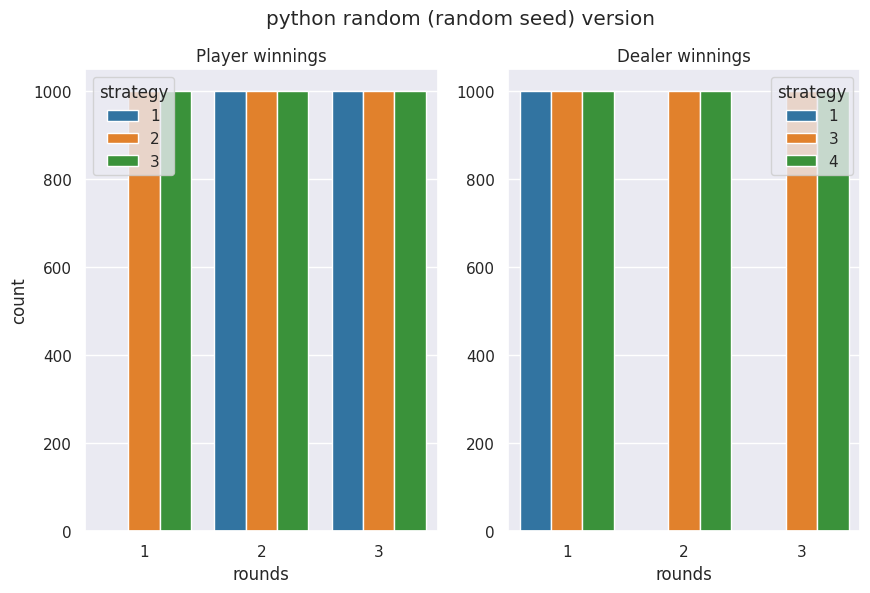

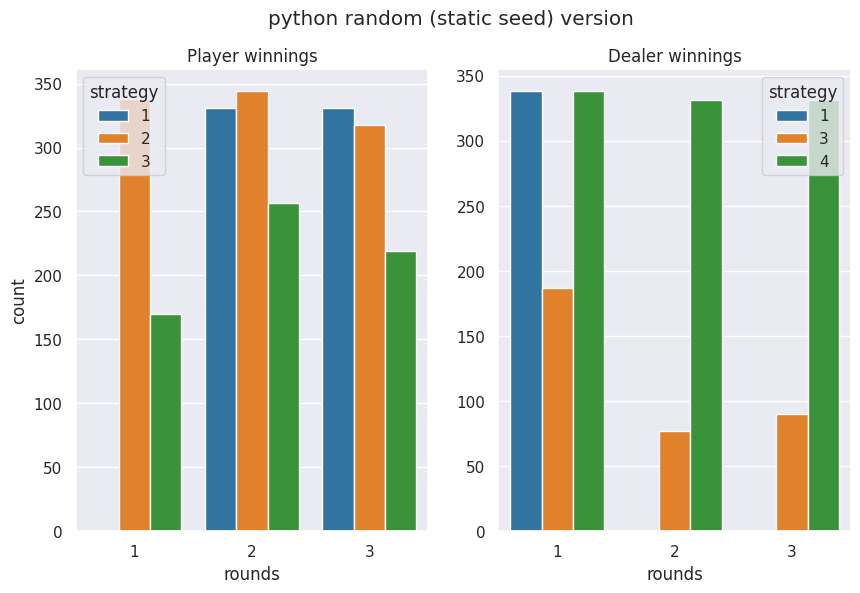

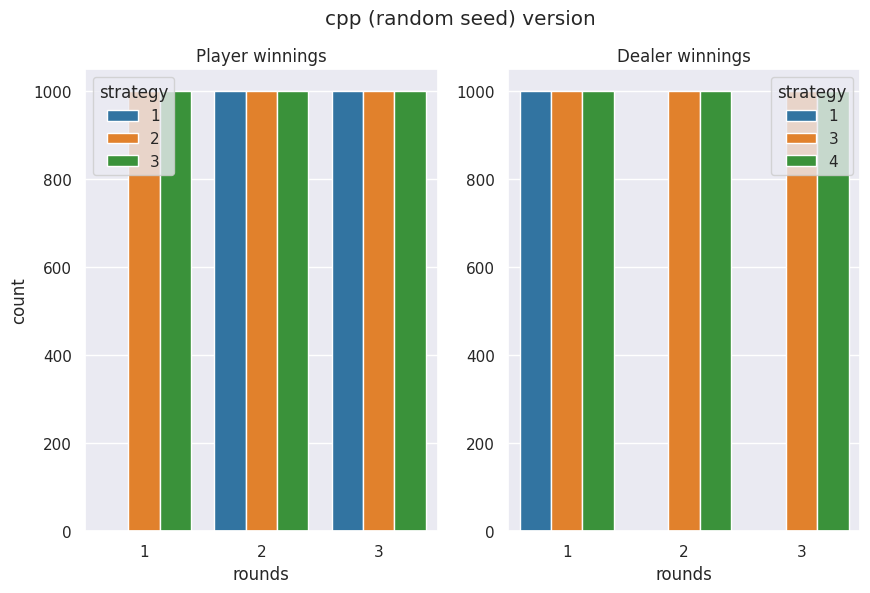

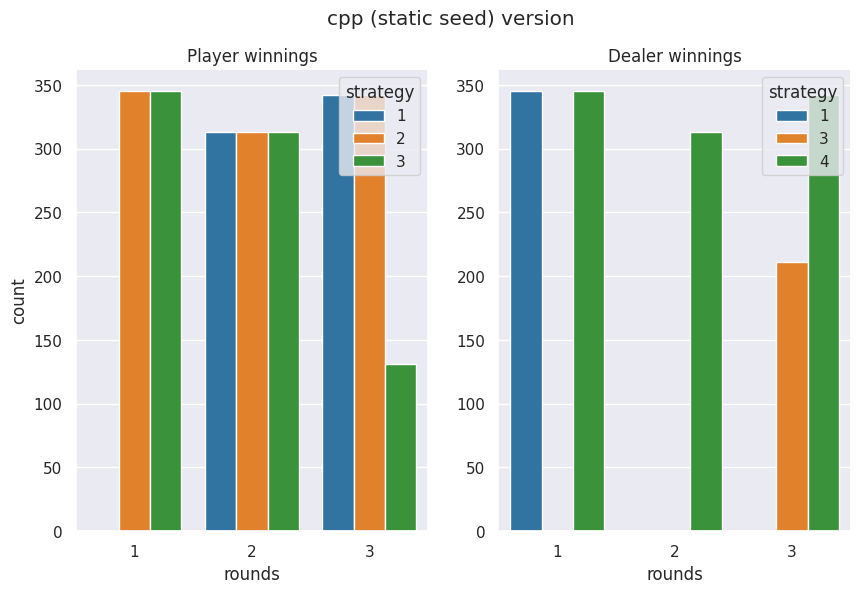

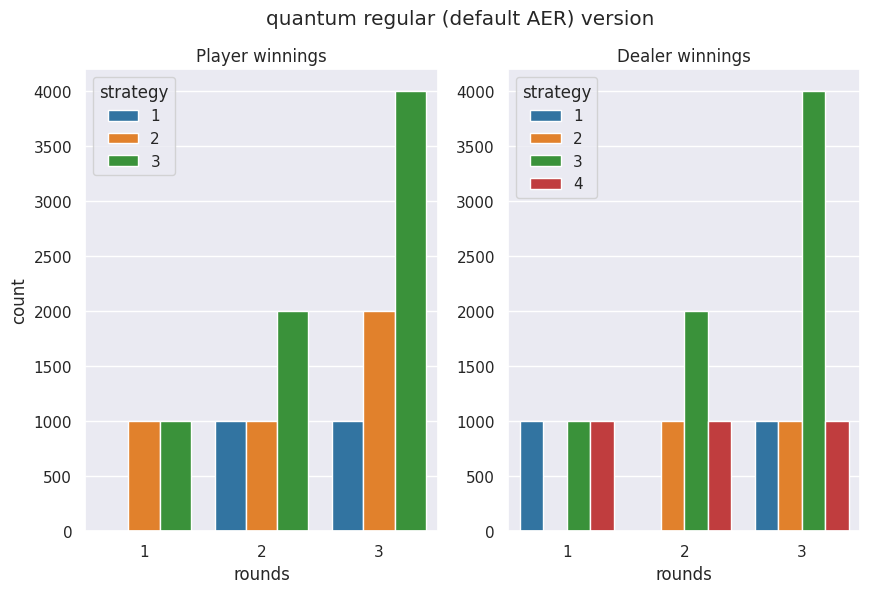

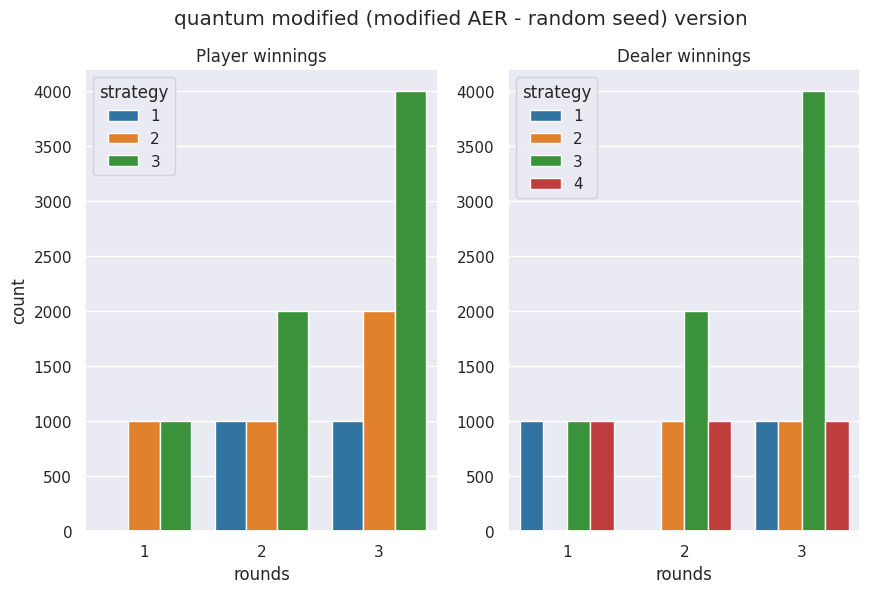

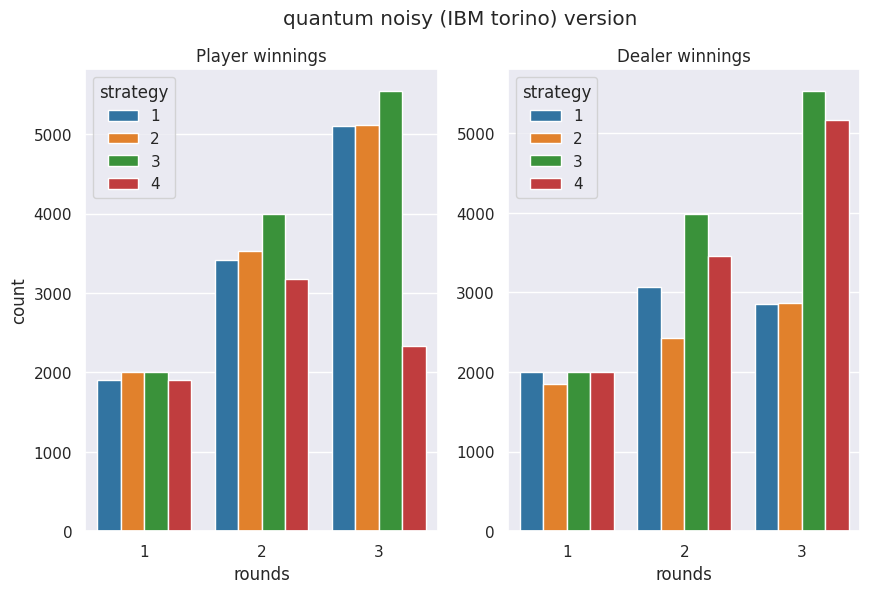

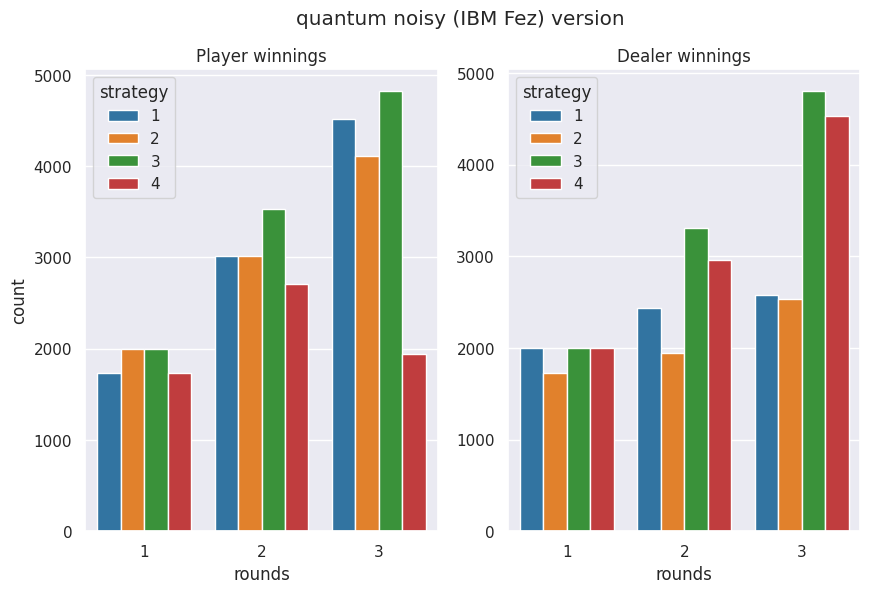

In [9]:
print("To Understand how many rounds each strategy takes to win")
for version in labels:
    subset = data[data["label"] == version]
    dealer_winnings = subset[subset["winner"] == "dealer"]
    player_winnings = subset[subset["winner"] == "player"]

    sns.set_theme(style="darkgrid")
    fig,ax = plt.subplots(1,2, figsize=(10,6))

    sns.countplot(data=player_winnings, x="rounds", ax=ax[0], palette="tab10", hue="strategy")
    ax[0].set_title("Player winnings")

    sns.countplot(data=dealer_winnings, x="rounds", ax=ax[1], palette="tab10", hue="strategy")
    ax[1].set_title("Dealer winnings")
    ax[1].set_ylabel("")

    fig.suptitle(f"{version} version")
    plt.savefig(os.path.join(TARGET_ASSETS_FOLDER, f"{version}-rounds-per-strategy.png"), bbox_inches="tight")

    plt.show()

To See how many times a version is better than the other based on how many wins


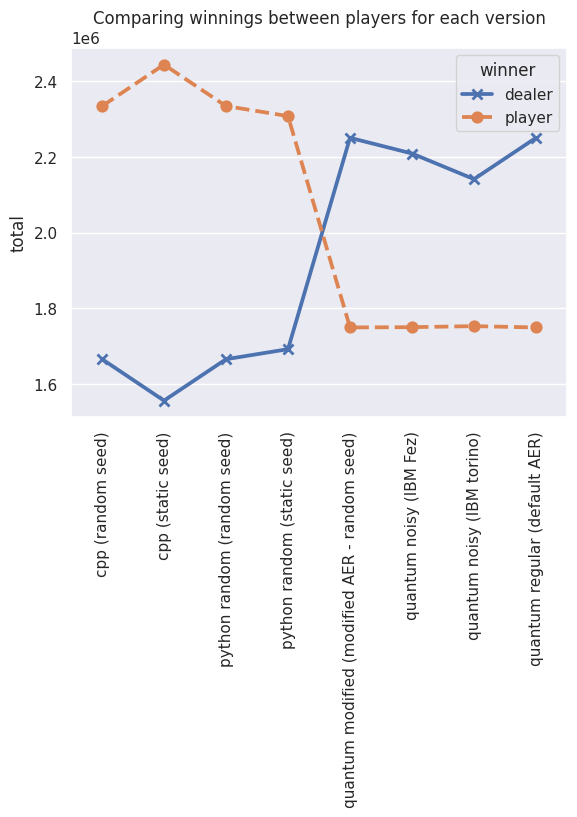

In [18]:
print("To See how many times a version is better than the other based on how many wins")

amount_of_winnings = data.groupby(["winner", "label"])["total"].sum().reset_index()

sns.set_theme(style="darkgrid")
plt.title("Comparing winnings between players for each version")
sns.pointplot(data=amount_of_winnings, x="label", y="total", hue="winner", linestyles=["-", "--"], markers=['x','o'])
plt.xlabel("")
plt.xticks(rotation=90)
plt.savefig(os.path.join(TARGET_ASSETS_FOLDER, "winnings-per-version.png"), bbox_inches="tight")
plt.show()

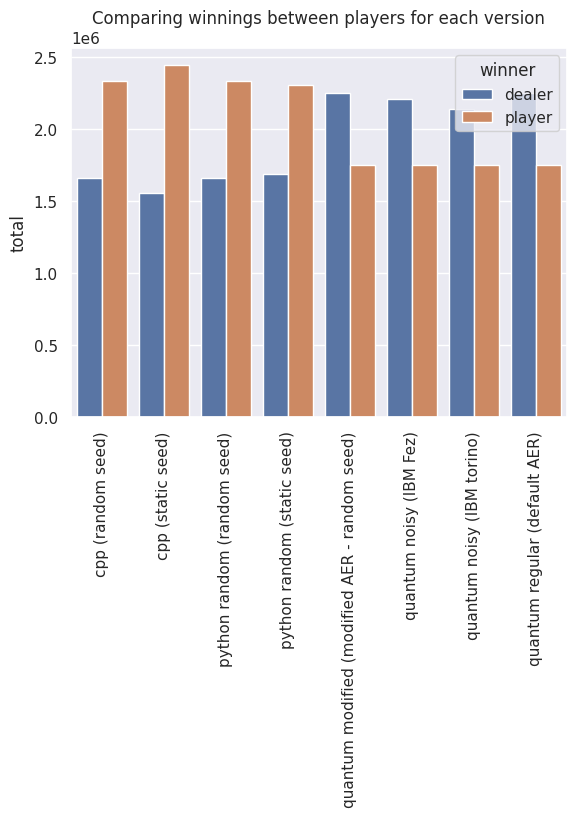

In [19]:
sns.set_theme(style="darkgrid")
plt.title("Comparing winnings between players for each version")
sns.barplot(data=amount_of_winnings, x="label", y="total", hue="winner")
plt.xlabel("")
plt.xticks(rotation=90)
plt.savefig(os.path.join(TARGET_ASSETS_FOLDER, "winnings-per-version-bars.png"), bbox_inches="tight")
plt.show()

How many rounds the players are winning per version per strategy


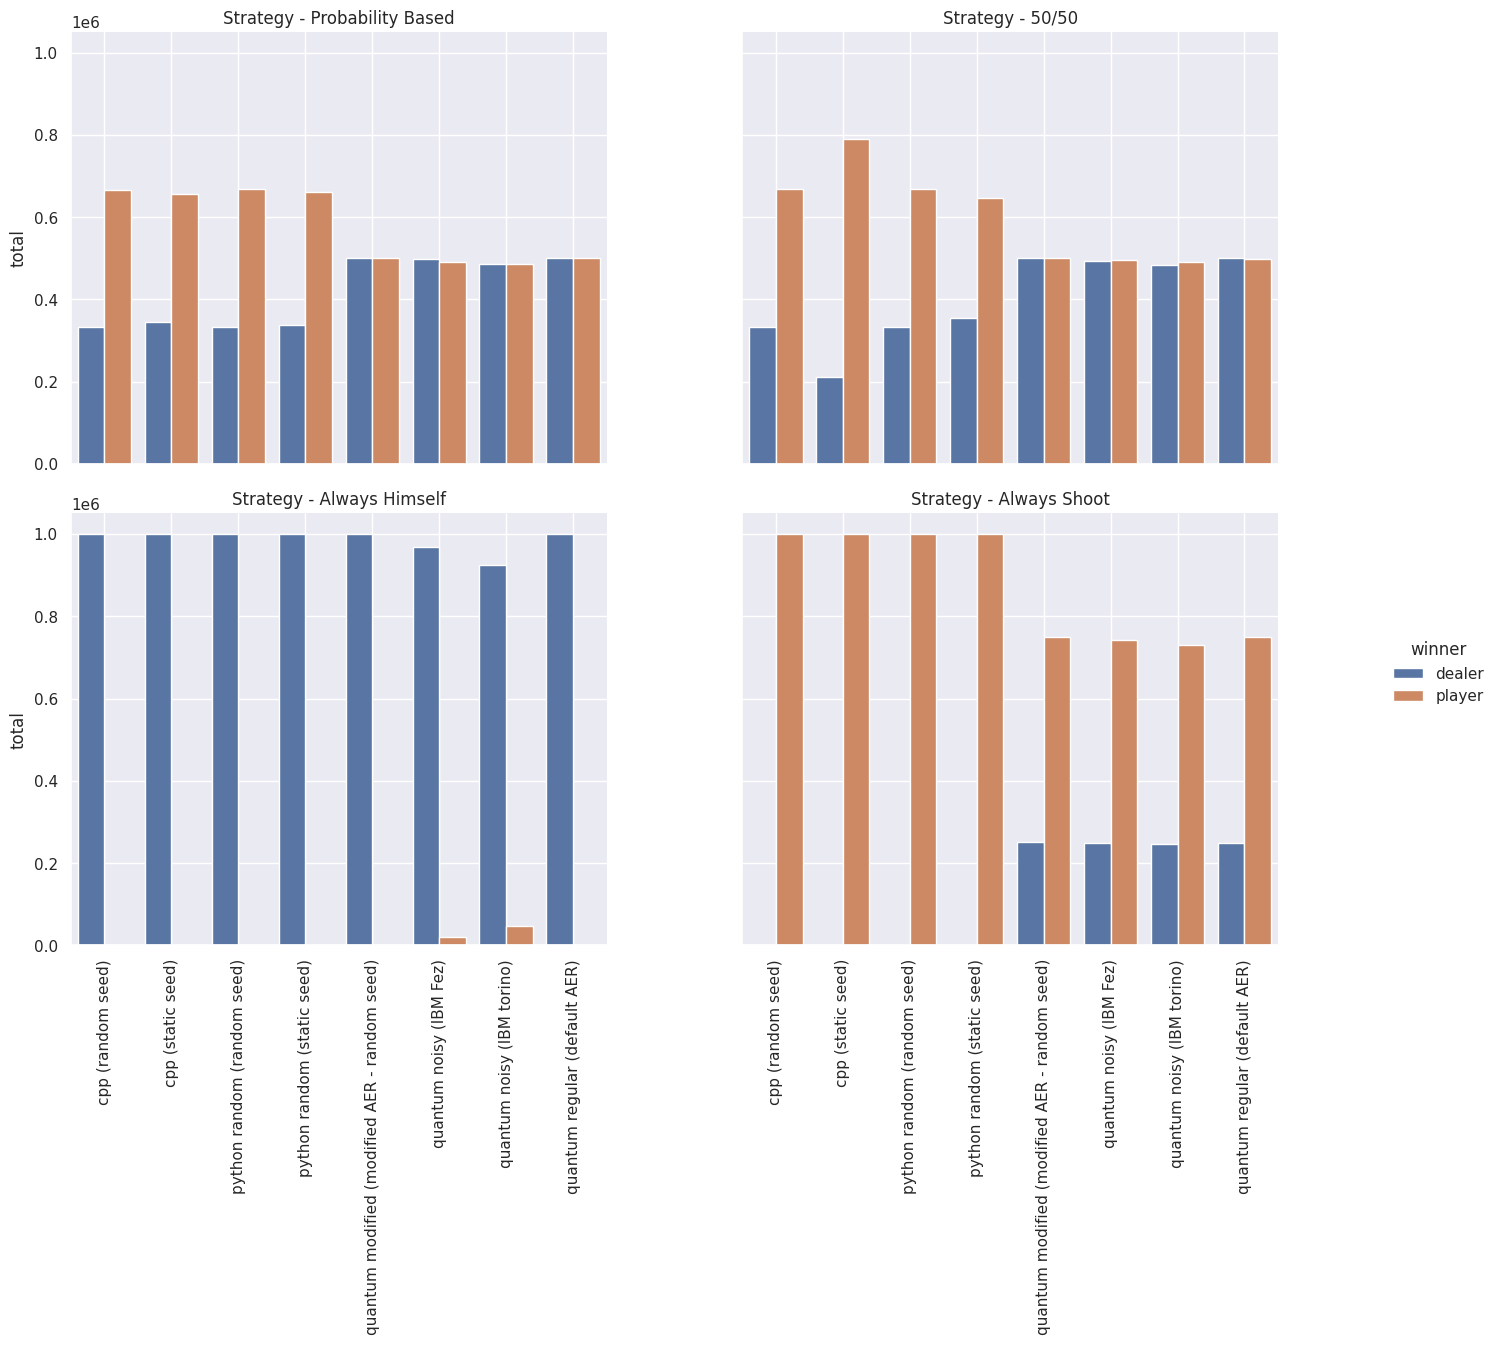

In [24]:
print("How many rounds the players are winning per version per strategy")

sns.set_theme(style="darkgrid")

winnings_per_strategy = data.groupby(["winner", "label", "strategy"])["total"].sum().reset_index()

for i,desc in enumerate(STRATEGIES_DESCRIPTION):
    winnings_per_strategy.loc[winnings_per_strategy["strategy"] == i+1,"desc"] = desc

g = sns.catplot(kind="bar", data=winnings_per_strategy,x="label", y="total", hue="winner", col="desc", col_wrap=2, aspect=1.4)
g.set_titles("Strategy - {col_name}")
g.set_xlabels("")
g.tight_layout()
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=90)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
plt.savefig(os.path.join(TARGET_ASSETS_FOLDER, "strategies-winnings.png"), bbox_inches="tight")
plt.show()

In [23]:
def fill_remaining_labels(subset:pd.DataFrame, strategy_i:int, portion:List[str]) -> pd.DataFrame:
    df = subset.copy()
    labels = subset.label.unique()
    not_present_labels = set(portion) - set(labels)

    for label in not_present_labels:
        df.loc[len(df)] = {
            "label":label,
            "strategy": strategy_i,
            1: 0,
            2: 0,
            3: 0
        }        
    return df

How many rounds each strategy take to win per version
max_rounds:  3


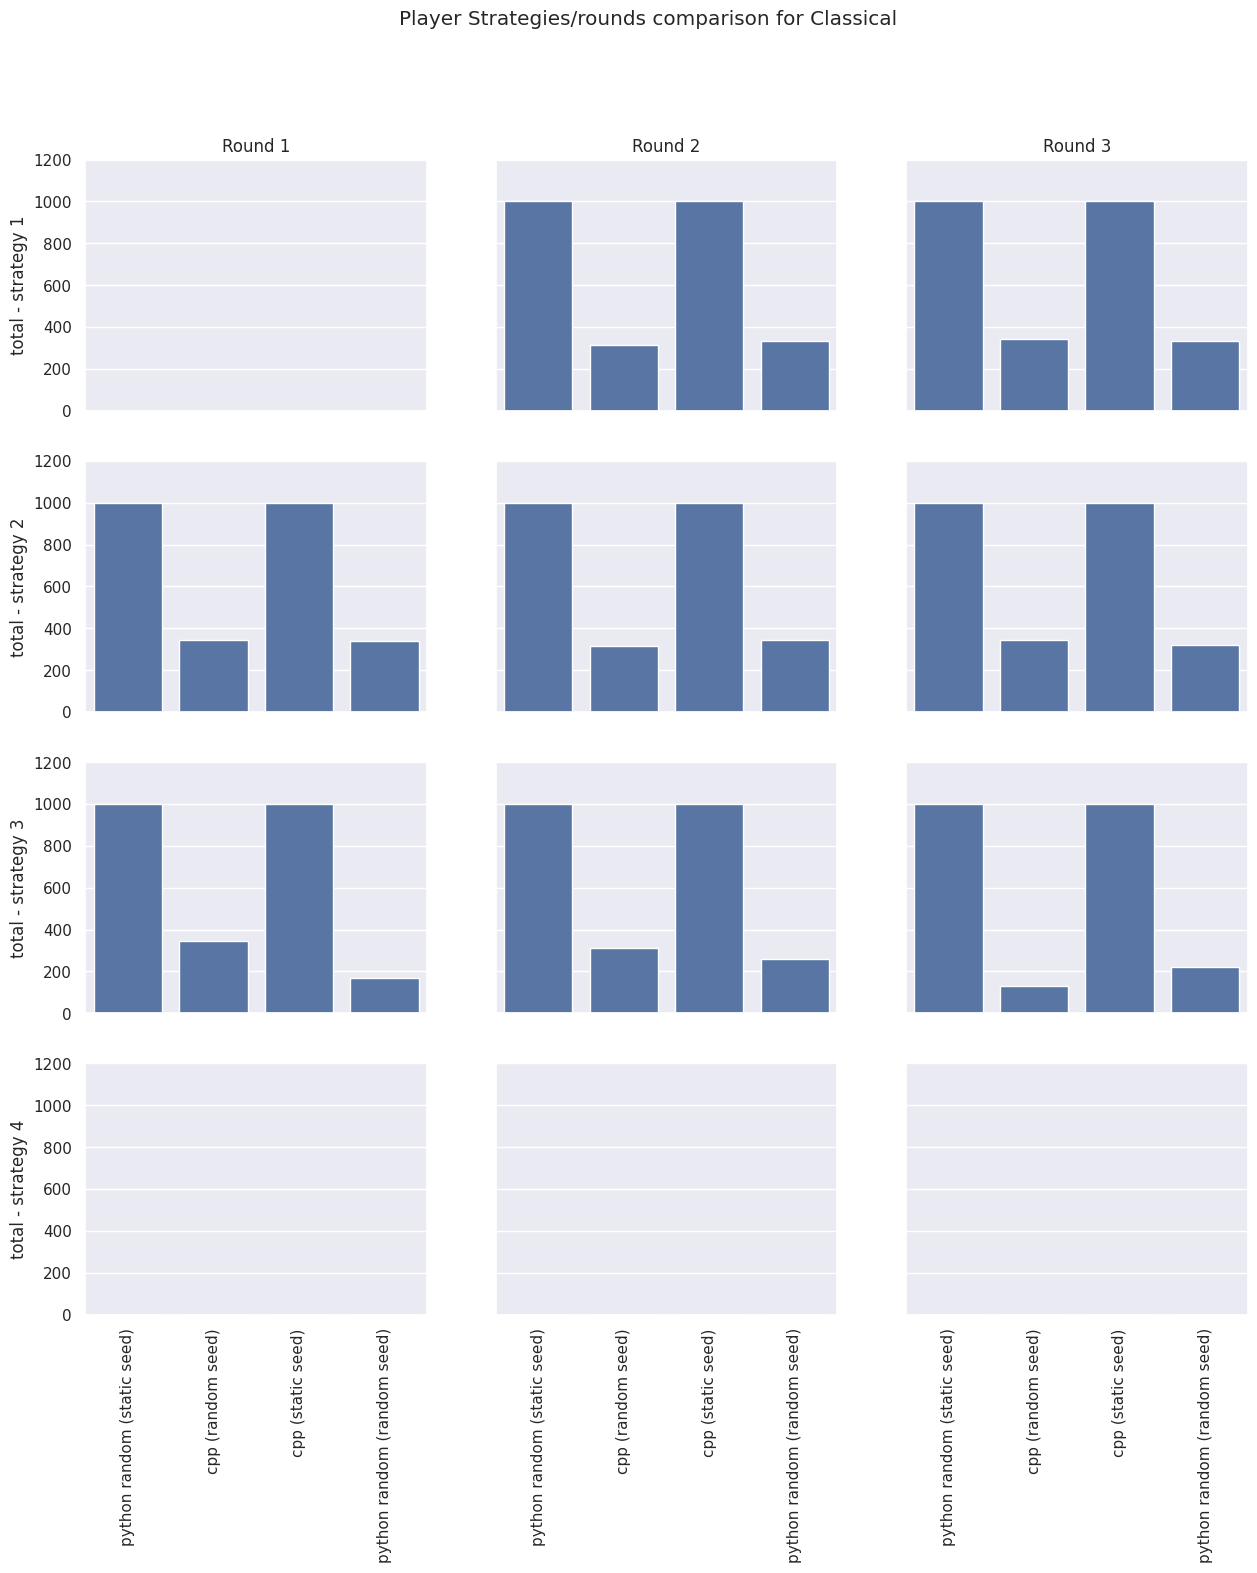

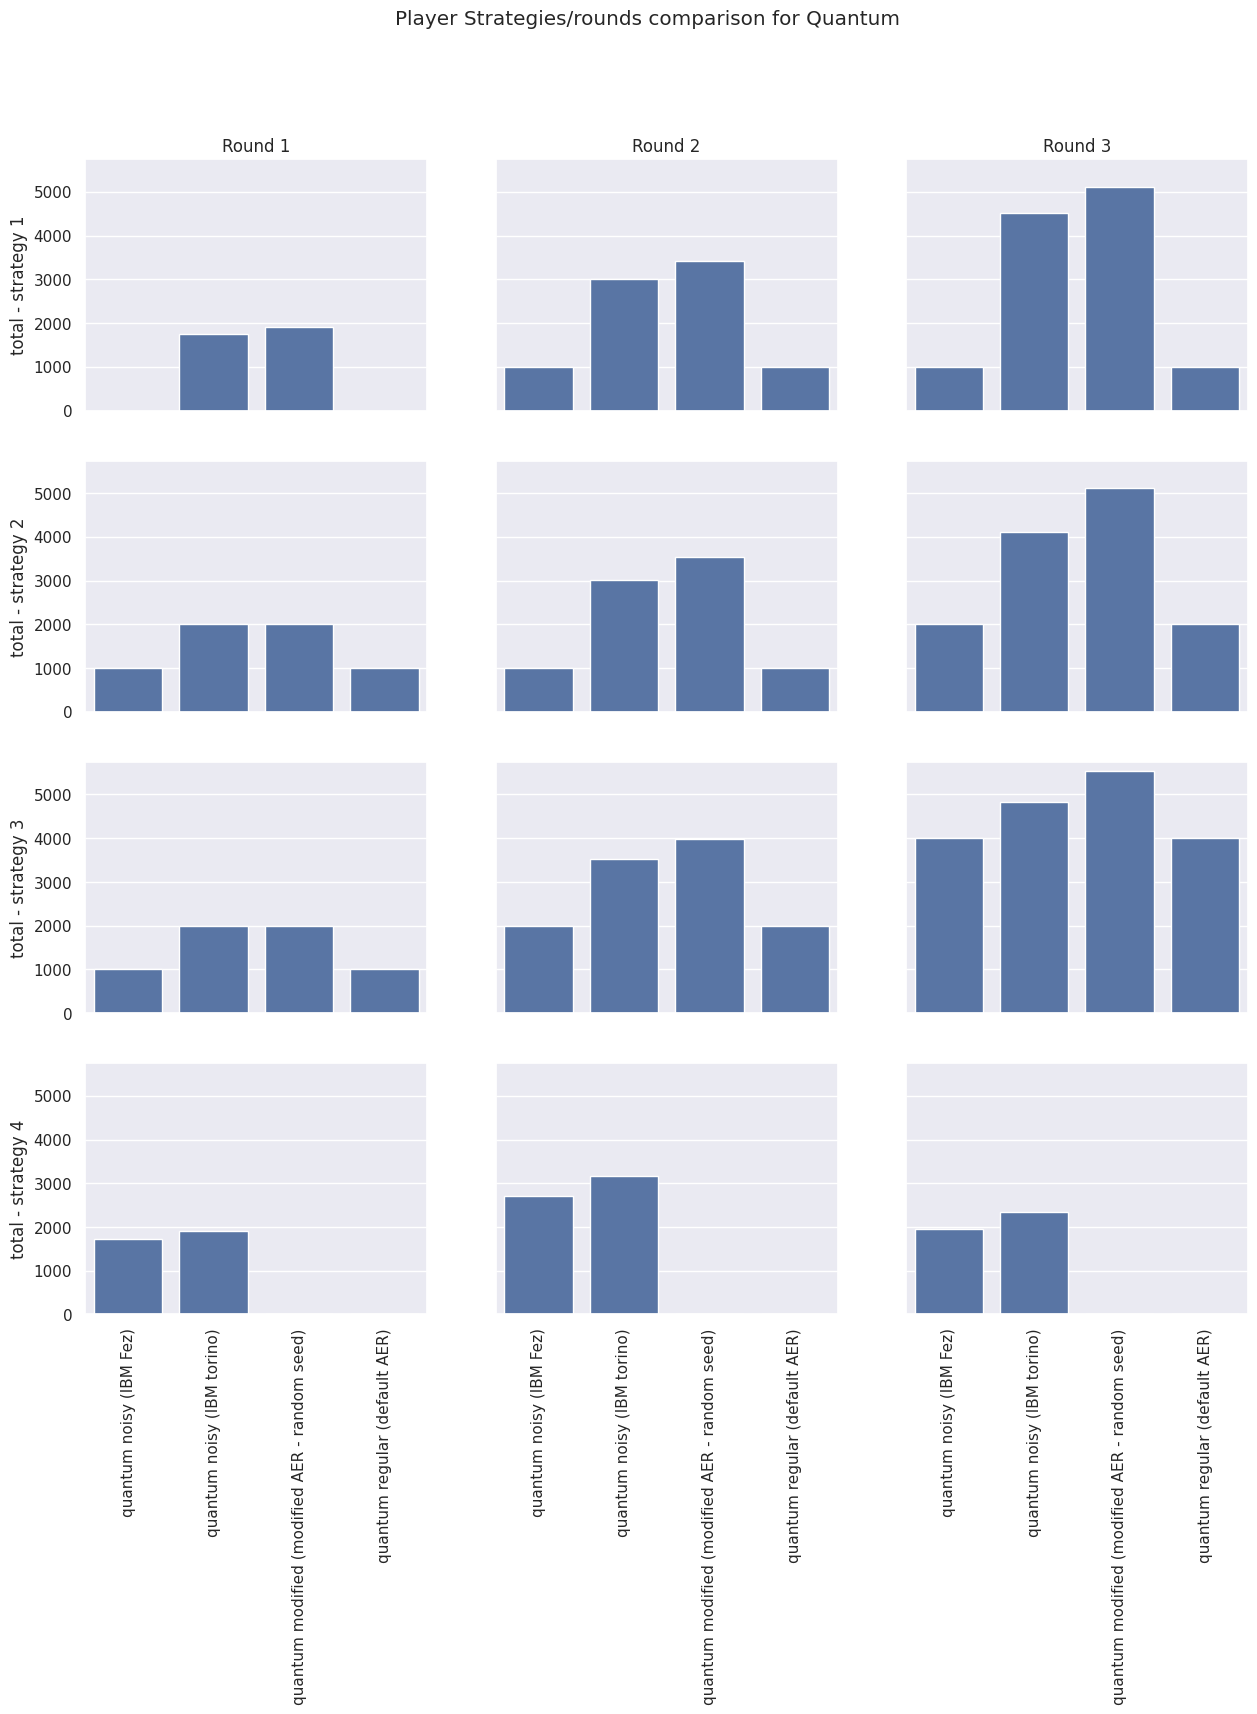

In [24]:
print("How many rounds each strategy take to win per version")


max_rounds = data.rounds.max()
print("max_rounds: ", max_rounds)


winnings_per_strategy_per_round = data[data['winner'] == 'player'].groupby(["label", "strategy", "rounds"])["rounds"].count().unstack().reset_index()

cols = max_rounds
rows = TOTAL_STRATEGIES

for name,portion in zip(("Classical", "Quantum"), (CLASSICAL_PORTION, QUANTUM_PORTION)):
    sns.set_theme(style="darkgrid")

    fig, ax = plt.subplots(rows,cols, figsize=(15, 15))
    fig.suptitle(f"Player Strategies/rounds comparison for {name}")

    max_y = winnings_per_strategy_per_round[winnings_per_strategy_per_round['label'].isin(portion)].max()[2:].max() + 200

    for strategy_i in range(rows):
        for rounds_j in range(cols):
            current_ax = ax[strategy_i,rounds_j]

            subset = fill_remaining_labels(
                winnings_per_strategy_per_round[(winnings_per_strategy_per_round["strategy"] == strategy_i+1) & (winnings_per_strategy_per_round['label'].isin(portion))],
                strategy_i,
                portion
            )
            sns.barplot(data=subset, x="label", y=rounds_j+1, ax=current_ax)
            current_ax.set_xlabel("")
            current_ax.set_title("")

            labels = current_ax.get_xticklabels()
            current_ax.set_xticklabels(labels, rotation=90)
            current_ax.set_ylim(0,max_y)

            if(strategy_i < rows-1):
                current_ax.set_xticklabels([])

            if(strategy_i == 0):
                current_ax.set_title(f"Round {rounds_j+1}")
            
            if(rounds_j == 0):
                current_ax.set_ylabel(f"total - strategy {strategy_i+1}")
            else:
                current_ax.set_ylabel("")
                current_ax.set_yticklabels([])
    plt.savefig(os.path.join(TARGET_ASSETS_FOLDER, f"strategies-rounds-comparison-{name}.png"), bbox_inches="tight")
    plt.show()


In [27]:
MAX_AMOUNT = TOTAL_RUNS * TOTAL_RUNS * TOTAL_STRATEGIES

for label in LABELS[:-2]:
    assert int(data[data["label"]==label]["total"].sum()) == MAX_AMOUNT, f"Invalid amount of winnings for {label} experiment"

for label in LABELS[-2:]:
    assert int(data[data["label"]==label]["total"].sum()) <= MAX_AMOUNT, f"Invalid amount of winnings for {label} experiment"